In [1]:
import torch
print('Version', torch.__version__)
print('CUDA enabled:', torch.cuda.is_available())
  
# Running this should then print out:
# Version 1.7.0+cu101 (or something like this)
# CUDA enabled: True

Version 1.7.0+cu101
CUDA enabled: True


In [2]:
from google.colab import drive
drive.mount('/gdrive')
!ls /gdrive

Mounted at /gdrive
MyDrive  Shareddrives


In [3]:
import os
BASE_PATH = '/gdrive/My Drive/colab_files/'
DATA_PATH = '/gdrive/My Drive/colab_files/mel_spec_dataset_large/'

#UNCOMMENT FOLLOWING SECTION TO UNTAR DATASETS
#MODIFY FILE NAMES AS NEEDED
'''
if not os.path.exists(DATA_PATH):
    os.makedirs(DATA_PATH)
print(os.getcwd())

os.chdir(BASE_PATH)
!ls
!tar -zxf mel_spec_data_amplified.tar.gz mel_spec_dataset_amplified/test_combined 
print('Extracted test set')
!tar -zxf mel_spec_data_amplified.tar.gz mel_spec_dataset_amplified/train_combined
print('Extracted train set')
!tar -zxf mel_spec_data_amplified.tar.gz mel_spec_dataset_amplified/train_data_ms_list.csv
!tar -zxf mel_spec_data_amplified.tar.gz mel_spec_dataset_amplified/test_data_ms_list.csv
print('Extracted data lists')
!cp "pt_util.py" "/gdrive/My Drive/colab_files/mel_spec_dataset_amplified/"
print('Copied pt_util')
#!ls -1 | wc -l
'''
os.chdir(DATA_PATH)
!ls

logs	pt_util.py   test_combined	    train_combined
my.png	__pycache__  test_data_ms_list.csv  train_data_ms_list.csv


In [4]:
import torch
import torch.nn as nn
from torchvision import datasets
from torchvision import transforms
import numpy as np
import torch.nn.functional as F
import torch.optim as optim
import csv
import sys
import pickle
import re
import pt_util

!ls

logs	pt_util.py   test_combined	    train_combined
my.png	__pycache__  test_data_ms_list.csv  train_data_ms_list.csv


In [5]:
def create_dict():
    dict = {}
    with open('train_data_ms_list.csv') as csv_file:
        csv_reader = csv.reader(csv_file, delimiter=',')
        count = 0
        for row in csv_reader:
            if row[1] not in dict:
                dict[row[1]] = count
                count = count + 1
    return dict

In [7]:
#COMBINED
class FreesoundDataset(torch.utils.data.Dataset):
    def __init__(self, data_file, dictionary, num_mset, dir):
        super(FreesoundDataset, self).__init__()
        self.data = []
        self.labels = []
        self.dict = dictionary
        row_count = 0
        with open(data_file) as csv_file:
            csv_reader = csv.reader(csv_file, delimiter=',')
            for row in csv_reader:
                self.labels.append(row[1])

        for i in range(num_mset):
            name = dir + 'MSet' + str(i) + '.npy'
            data_np = np.load(name)
            for sample in data_np:
                self.data.append(sample)
            print('read ' + name)


    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        data_array = self.data[idx]
        data_image = np.stack([data_array]*3)
        data_image = data_image.astype('float32')
        label_num = self.dict[self.labels[idx]]
        return data_image, label_num

    def num_classes(self):
        return len(self.dict)   


dictionary = create_dict()
print(dictionary)
#COMBINED
print('Loading test data set...')
#CHANGE NUM TO 19 FOR TEST PADDED, 16 FOR UNPADDED
data_test = FreesoundDataset('test_data_ms_list.csv', dictionary, 16, 'test_combined/') 
print('Length of test dataset:' + str(len(data_test)))

print('Loading train data set...')
#CHANGE NUM TO 123 FOR COMPLETE SET, 156 FOR AMPLIFIED, 37 FOR VERIFIED
data_train = FreesoundDataset('train_data_ms_list.csv', dictionary, 123, 'train_combined/')
print('Length of train data set:' + str(len(data_train)))
print('Number of classes:' + str(data_train.num_classes()))


{'Hi-hat': 0, 'Saxophone': 1, 'Glockenspiel': 2, 'Cello': 3, 'Knock': 4, 'Gunshot_or_gunfire': 5, 'Clarinet': 6, 'Computer_keyboard': 7, 'Keys_jangling': 8, 'Snare_drum': 9, 'Writing': 10, 'Laughter': 11, 'Tearing': 12, 'Fart': 13, 'Oboe': 14, 'Flute': 15, 'Cough': 16, 'Telephone': 17, 'Bark': 18, 'Chime': 19, 'Bus': 20, 'Squeak': 21, 'Scissors': 22, 'Harmonica': 23, 'Gong': 24, 'Microwave_oven': 25, 'Double_bass': 26, 'Shatter': 27, 'Fireworks': 28, 'Bass_drum': 29, 'Cowbell': 30, 'Electric_piano': 31, 'Meow': 32, 'Tambourine': 33, 'Applause': 34, 'Trumpet': 35, 'Acoustic_guitar': 36, 'Drawer_open_or_close': 37, 'Violin_or_fiddle': 38, 'Finger_snapping': 39, 'Burping_or_eructation': 40}
Loading test data set...
read test_combined/MSet0.npy
read test_combined/MSet1.npy
read test_combined/MSet2.npy
read test_combined/MSet3.npy
read test_combined/MSet4.npy
read test_combined/MSet5.npy
read test_combined/MSet6.npy
read test_combined/MSet7.npy
read test_combined/MSet8.npy
read test_combine

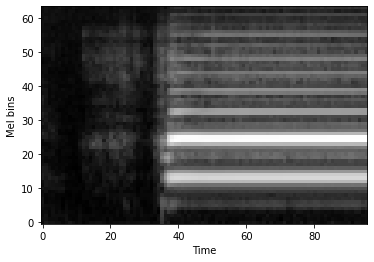

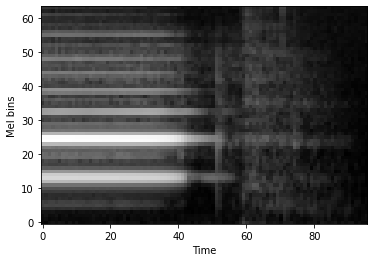

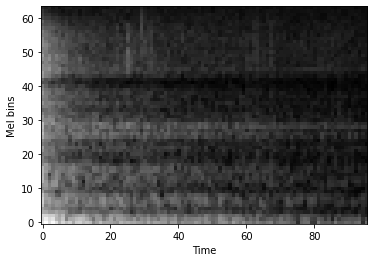

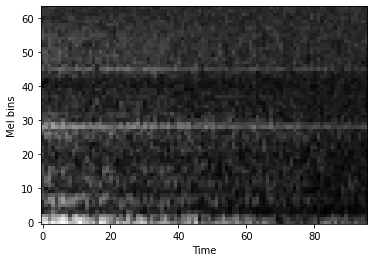

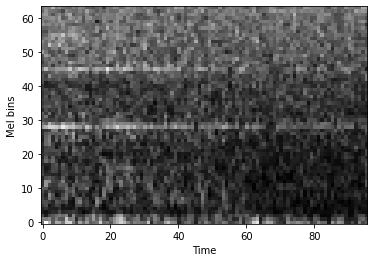

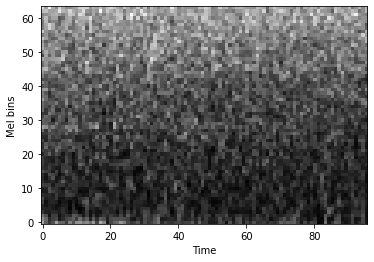

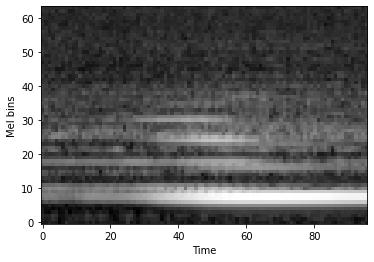

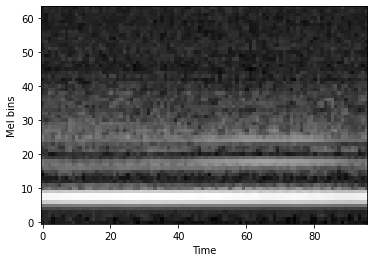

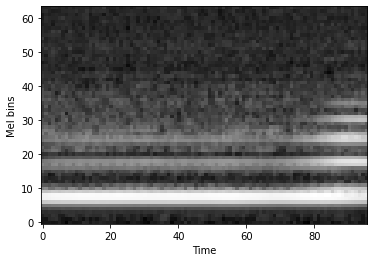

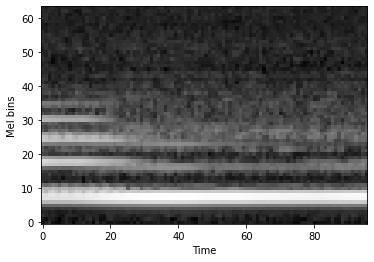

In [8]:
#TO DISPLAY MEL SPECTOGRAMS
from matplotlib import pyplot as plt
for i in range (10):
  data, label = data_test.__getitem__(i)
  data1 = np.transpose(data[0])
  plt.imshow(data1 , interpolation='nearest')
  plt.gray()
  plt.gca().invert_yaxis()
  plt.xlabel('Time')
  plt.ylabel('Mel bins')
  plt.show()




In [9]:
#preparing pretrained network
import torchvision.models as models
from torchsummary import summary
def get_vgg_model():
  model = models.vgg11(pretrained = True)
  model.features = nn.Sequential(*[model.features[i] for i in range(16)])
  model.avgpool = nn.Identity()
  model.classifier[0] =  nn.Linear(12288, 4096)
  model.classifier[6] = nn.Linear(4096, 41)
  
  #freezing weights from all layers
  for param in model.parameters(): # freeze
    param.requires_grad = False
  
  #unfreezing weight for classifier layers
  for i in range(7):
    for param in model.classifier[i].parameters(): # train the last linear layer.
      param.requires_grad = True
  model = model.cuda()
  #print(model)
  summary(model, (3, 96, 64))
  return model


In [10]:
import torchvision.models as models
def get_resnet_model():
  model_r = models.resnet18(pretrained = True)
  model_r.layer4 = nn.Identity()
  model_r.avgpool = nn.Identity()
  model_r.fc = nn.Linear(6144, 41)
  
  for param in model_r.parameters():
      param.requires_grad = False
      
  for param in model_r.fc.parameters():
    param.requires_grad = True
    
  model_r = model_r.cuda()
  summary(model_r, (3, 96, 64))
  return model_r

In [11]:
def save_model(model, file_path, num_to_keep=1):
    pt_util.save(model, file_path, num_to_keep)

def load_model(model, file_path):
    print('loading model')
    pt_util.restore(model, file_path)

def load_last_model(model, dir_path):
    print('loading last model')
    return pt_util.restore_latest(model, dir_path)


In [12]:
import time
def train(model, device, train_loader, optimizer, epoch, log_interval):
    model.train()
    losses = []
    criterion = F.cross_entropy
    for batch_idx, (data, label) in enumerate(train_loader):
        data, label = data.to(device), label.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, label, reduction='mean')
        losses.append(loss.item())
        loss.backward()
        optimizer.step()
        if batch_idx % log_interval == 0:
            print('{} Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                time.ctime(time.time()),
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))
    return np.mean(losses)

def test(model, device, test_loader, log_interval=None, traindata = False):
    model.eval()
    test_loss = 0
    correct = 0
    criterion = F.cross_entropy
    if traindata:
      name = 'Train'
    else:
      name = 'Test'
    with torch.no_grad():
        for batch_idx, (data, label) in enumerate(test_loader):
            data, label = data.to(device), label.to(device)
            output = model(data)
            test_loss_on = criterion(output, label, reduction='sum').item()
            test_loss += test_loss_on
            pred = output.max(1)[1]
            correct_mask = pred.eq(label.view_as(pred))
            num_correct = correct_mask.sum().item()
            correct += num_correct
            
            if log_interval is not None and batch_idx % log_interval == 0:
                print('{} Data: [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                    time.ctime(time.time()),
                    batch_idx * len(data), len(test_loader.dataset),
                    100. * batch_idx / len(test_loader), test_loss_on))
    test_loss /= len(test_loader.dataset)
    test_accuracy = 100. * correct / len(test_loader.dataset)

    print('\n' + name + ' set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset), test_accuracy))
    
    return test_loss, test_accuracy

Using device cuda
num cpus: 2
Loaded data


Downloading: "https://download.pytorch.org/models/vgg11-bbd30ac9.pth" to /root/.cache/torch/hub/checkpoints/vgg11-bbd30ac9.pth



----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 96, 64]           1,792
              ReLU-2           [-1, 64, 96, 64]               0
         MaxPool2d-3           [-1, 64, 48, 32]               0
            Conv2d-4          [-1, 128, 48, 32]          73,856
              ReLU-5          [-1, 128, 48, 32]               0
         MaxPool2d-6          [-1, 128, 24, 16]               0
            Conv2d-7          [-1, 256, 24, 16]         295,168
              ReLU-8          [-1, 256, 24, 16]               0
            Conv2d-9          [-1, 256, 24, 16]         590,080
             ReLU-10          [-1, 256, 24, 16]               0
        MaxPool2d-11           [-1, 256, 12, 8]               0
           Conv2d-12           [-1, 512, 12, 8]       1,180,160
             ReLU-13           [-1, 512, 12, 8]               0
           Conv2d-14           [-1, 51

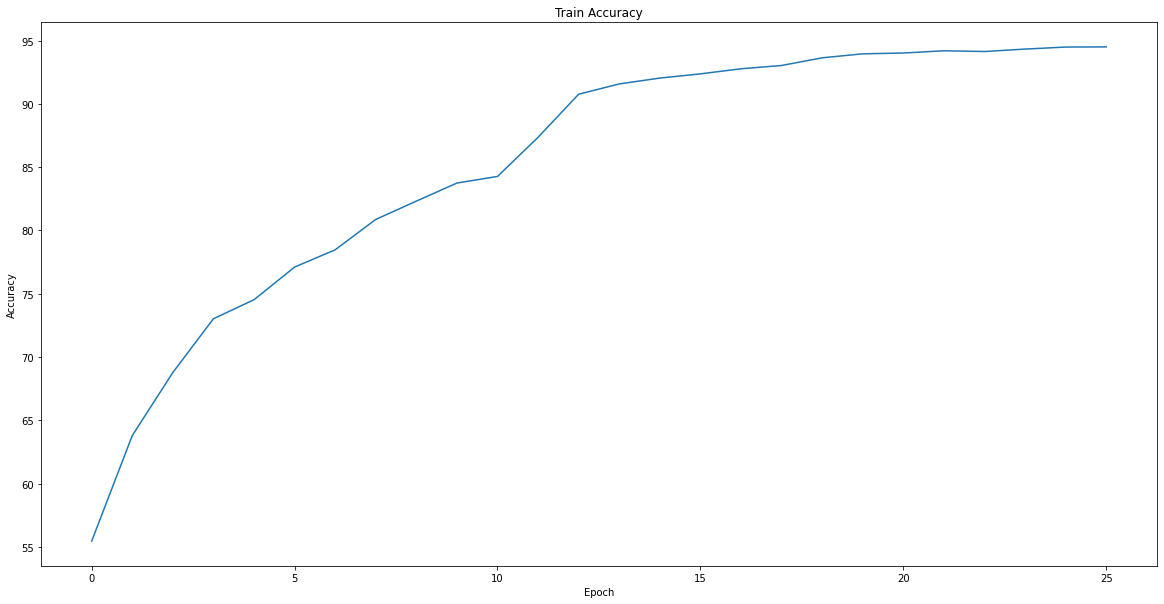

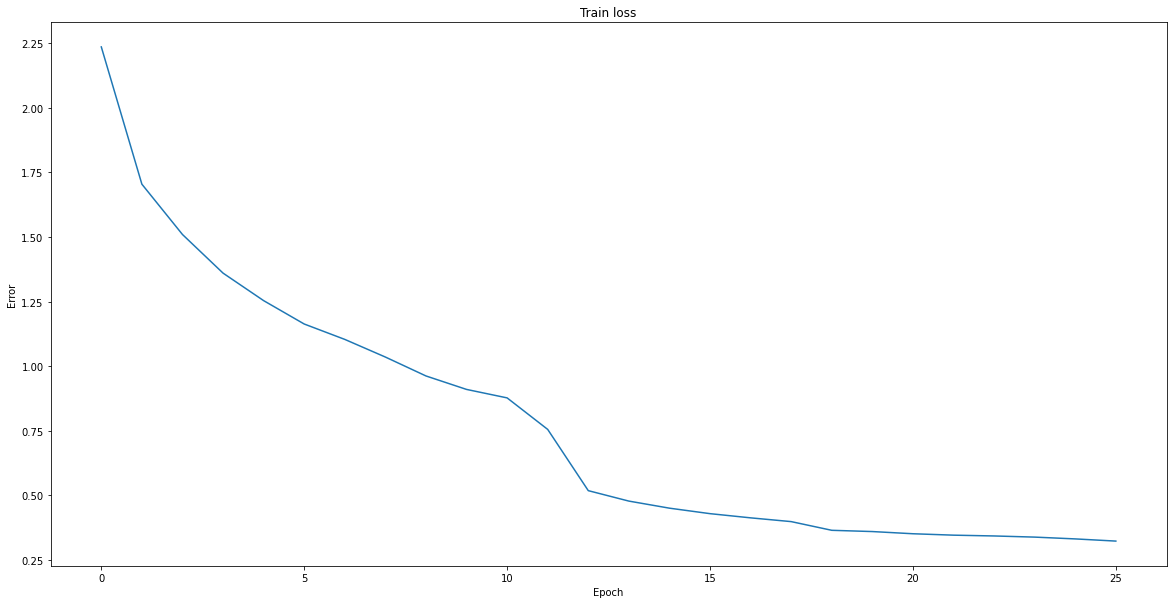

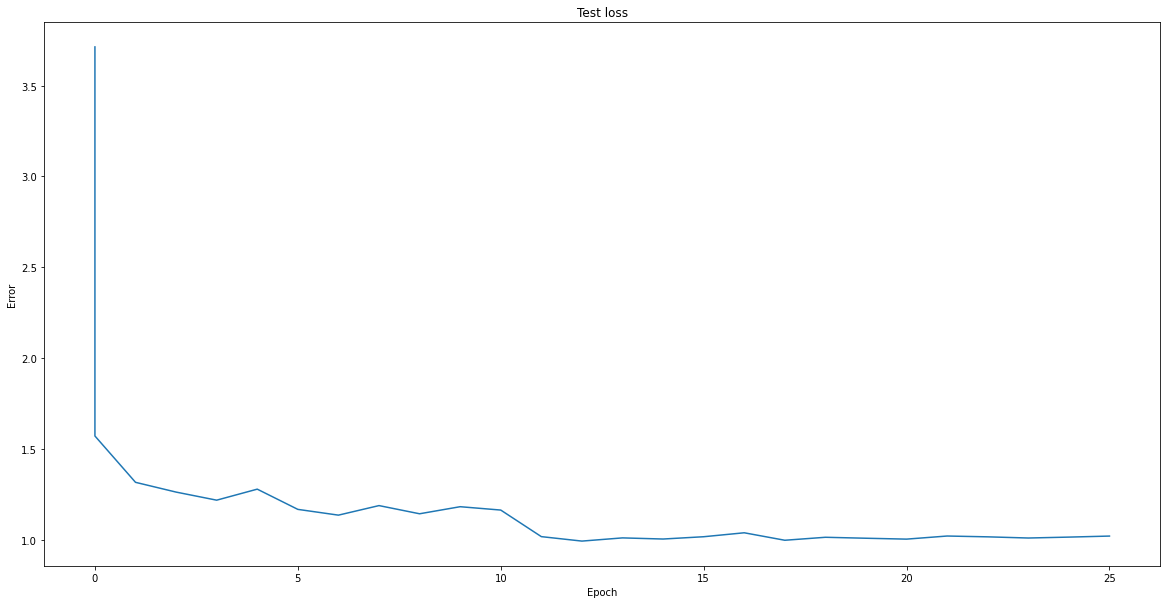

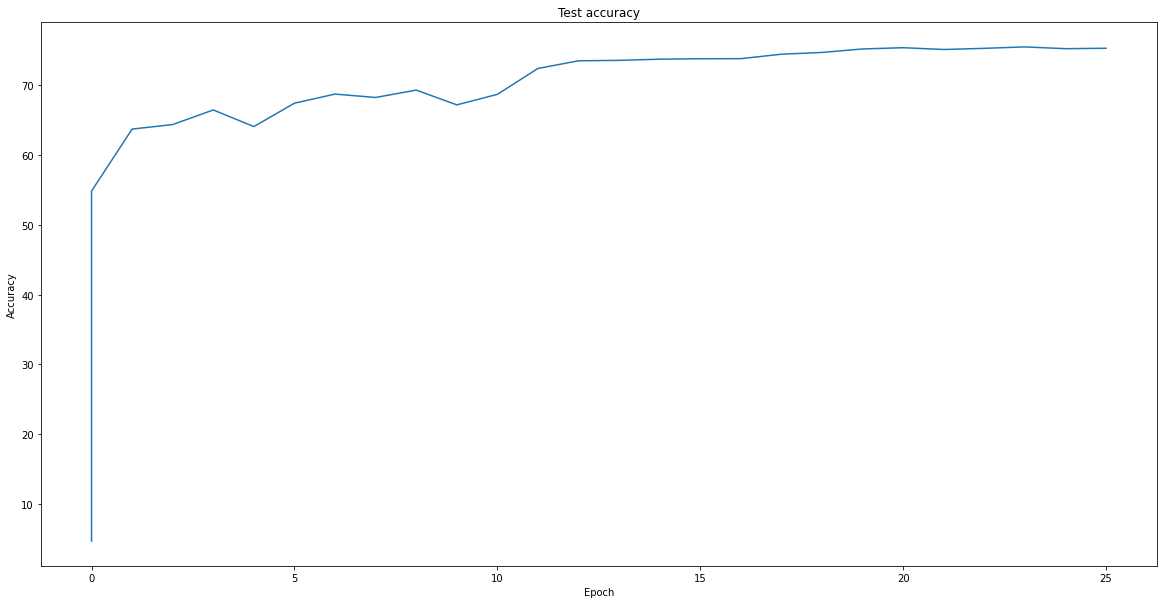

In [13]:
BATCH_SIZE = 128
TEST_BATCH_SIZE = 10
EPOCHS = 10
LEARNING_RATE = 0.01
MOMENTUM = 0.9
USE_CUDA = True
SEED = 0
PRINT_INTERVAL = 50
WEIGHT_DECAY = 0

VERSION = "8.00" # increment this to start a new experiment
LOG_PATH = DATA_PATH + 'logs/' + VERSION + '/'

use_cuda = USE_CUDA and torch.cuda.is_available()

device = torch.device("cuda" if use_cuda else "cpu")
print('Using device', device)
import multiprocessing
print('num cpus:', multiprocessing.cpu_count())

kwargs = {'num_workers': multiprocessing.cpu_count(),
          'pin_memory': True} if use_cuda else {}

train_loader = torch.utils.data.DataLoader(data_train, batch_size=BATCH_SIZE,
                                           shuffle=True, **kwargs)
test_loader = torch.utils.data.DataLoader(data_test, batch_size=TEST_BATCH_SIZE,
                                          shuffle=False, **kwargs)
print('Loaded data')
#CHANGE TO TRY RESNET OR VGG
model = get_vgg_model()
#model = get_resnet_model()

optimizer = optim.SGD(model.parameters(), lr=LEARNING_RATE, momentum=MOMENTUM, weight_decay=WEIGHT_DECAY)
start_epoch = load_last_model(model, LOG_PATH)

train_accuracies, train_losses, test_losses, test_accuracies = pt_util.read_log(LOG_PATH + 'log.pkl', ([], [], [], []))
test_loss, test_accuracy = test(model, device, test_loader)

test_losses.append((start_epoch, test_loss))
test_accuracies.append((start_epoch, test_accuracy))
best_accuracy = None
lr = LEARNING_RATE
try:
    for epoch in range(start_epoch, EPOCHS + 1):
        #lr = LEARNING_RATE * np.power(0.25, (int(epoch / 6)))
        optimizer = optim.SGD(model.parameters(), lr, momentum=MOMENTUM, weight_decay=WEIGHT_DECAY)
        train_loss = train(model, device, train_loader, optimizer, epoch, PRINT_INTERVAL)
        __, train_accuracy = test(model, device, train_loader, log_interval=300, traindata=True)
        test_loss, test_accuracy = test(model, device, test_loader, log_interval=100)
        train_accuracies.append((epoch, train_accuracy))
        train_losses.append((epoch, train_loss))
        test_losses.append((epoch, test_loss))
        test_accuracies.append((epoch, test_accuracy))
        pt_util.write_log(LOG_PATH + '.pkl', (train_accuracies, train_losses, test_losses, test_accuracies))
        if best_accuracy == None or test_accuracy > best_accuracy:
            best_accuracy = test_accuracy
            save_model(model, LOG_PATH + '%03d.pt' % epoch)

    for param in model.parameters(): # unfreeze
      param.requires_grad = True    
    tuning_epochs = 15
    
    
    for epoch in range(tuning_epochs):
        lr = LEARNING_RATE * np.power(0.25, (int((EPOCHS + 1 + epoch) / 6)))
        #lr = LEARNING_RATE * np.power(0.25, (int((epoch) / 6)))
        optimizer = optim.SGD(model.parameters(), lr, momentum=MOMENTUM, weight_decay=0)
        train_loss = train(model, device, train_loader, optimizer, EPOCHS + 1 + epoch, PRINT_INTERVAL)

        __ , train_accuracy = test(model, device, train_loader, log_interval=300, traindata=True)
        test_loss, test_accuracy = test(model, device, test_loader, log_interval=100)
        
        train_accuracies.append((EPOCHS + 1 + epoch, train_accuracy))
        train_losses.append((EPOCHS + 1 + epoch, train_loss))
        test_losses.append((EPOCHS + 1 + epoch, test_loss))
        test_accuracies.append((EPOCHS + 1 + epoch, test_accuracy))
        pt_util.write_log(LOG_PATH + '.pkl', (train_accuracies, train_losses, test_losses, test_accuracies))
        if best_accuracy == None or test_accuracy > best_accuracy:
            best_accuracy = test_accuracy
            save_model(model, LOG_PATH + '%03d.pt' % (epoch + EPOCHS + 1) ) 
       
    
except KeyboardInterrupt as ke:
    print('Interrupted')
except:
    import traceback
    traceback.print_exc()
finally:
    save_model(model, LOG_PATH + '%03d.pt' % (epoch + EPOCHS + 1), 0)
    ep, val = zip(*train_accuracies)
    pt_util.plot(ep, val, 'Train Accuracy', 'Epoch', 'Accuracy')
    ep, val = zip(*train_losses)
    pt_util.plot(ep, val, 'Train loss', 'Epoch', 'Error')
    ep, val = zip(*test_losses)
    pt_util.plot(ep, val, 'Test loss', 'Epoch', 'Error')
    ep, val = zip(*test_accuracies)
    pt_util.plot(ep, val, 'Test accuracy', 'Epoch', 'Accuracy')



In [21]:
def print_metrics(model, data_loader, num_classes): 

    target_positive = np.zeros(num_classes)
    predicted_positive = np.zeros(num_classes)
    true_positive = np.zeros(num_classes)
    true_negative = np.zeros(num_classes)
    precision = np.zeros(num_classes)
    recall = np.zeros(num_classes)
    f1score = np.zeros(num_classes)
    perclass_acc = np.zeros(num_classes)

    with torch.no_grad():
        for j, (inputs, classes) in enumerate(data_loader):
            inputs = inputs.to(device)
            classes = classes.to(device)
            outputs = model(inputs)
            #UNCOMMENT THIS FOR NONE CLASS TESTING
            '''
            all_predicted_probs = F.softmax(outputs, dim=1)
            predicted = torch.max(all_predicted_probs, 1)
            pred_probs = predicted[0]
            pred_classes = predicted[1]
            for i in range(len(pred_probs)):
                if pred_probs[i] < 0.5:
                    pred_classes[i] = 41
            '''
            #change to 42 for none
            for i in range(41):
                #predicted_classes = pred_classes == i
                predicted_classes = torch.argmax(outputs, dim=1) == i
                target_positive[i] += torch.sum(classes == i).float()
                predicted_positive[i] += torch.sum(predicted_classes).float()
                for k in range(len(predicted_classes)):
                    if classes[k] == i and predicted_classes[k]:
                        true_positive[i] += 1
                    if predicted_classes[k] == False and classes[k] != i:
                        true_negative[i] += 1

    for i in range(len(f1score)):
        recall[i] = true_positive[i] / target_positive[i]
        precision[i] = true_positive[i] / predicted_positive[i]
        f1score[i] = (2 * precision[i] * recall[i]) / (precision[i] + recall[i])
        all_samp = target_positive[i] + predicted_positive[i] - true_positive[i] + true_negative[i]
        perclass_acc[i] = (true_positive[i] + true_negative[i]) / all_samp

    print('CLASS NAME\t' + 'CLASS ACCURACY  \t' + 'PRECISION\t\t' + 'RECALL   \t\t' + 'F1 SCORE\t' + '\t' + 'SAMPLES'.expandtabs(40))
    for name in dictionary:
        count = dictionary[name]
        string = name + '\t' + '%.4f'%perclass_acc[count] + '\t' + '%.4f'%precision[count] + '\t' + '%.4f'%recall[count] + '\t' + '%.4f'%f1score[count] + '\t' + str(target_positive[count])
        print(string.expandtabs(22))

    print('Average class accuracy: ' + '%.4f'%np.mean(perclass_acc))
    print('Average precision: ' + '%.4f'%np.mean(precision))
    print('Average recall: ' + '%.4f'%np.mean(recall))
    print('Average F1 score: ' + '%.4f'%np.mean(f1score))


In [17]:
print_metrics(model, test_loader, data_train.num_classes())

CLASS NAME	CLASS ACCURACY  	PRECISION		RECALL   		F1 SCORE		SAMPLES
Hi-hat                0.9976                0.7027                0.7647                0.7324                34.0
Saxophone             0.9848                0.9735                0.8509                0.9081                691.0
Glockenspiel          0.9791                0.3916                0.5078                0.4422                128.0
Cello                 0.9907                0.8694                0.8785                0.8739                288.0
Knock                 0.9810                0.5542                0.5509                0.5526                167.0
Gunshot_or_gunfire    0.9816                0.7655                0.5023                0.6066                221.0
Clarinet              0.9866                0.7881                0.9539                0.8631                347.0
Computer_keyboard     0.9821                0.8468                0.6568                0.7398                303.0
Keys_

In [18]:
print_metrics(model, train_loader, data_train.num_classes())

CLASS NAME	CLASS ACCURACY  	PRECISION		RECALL   		F1 SCORE		SAMPLES
Hi-hat                0.9995                0.9860                0.9821                0.9841                1006.0
Saxophone             0.9992                0.9974                0.9759                0.9865                1951.0
Glockenspiel          0.9906                0.4525                0.9794                0.6190                486.0
Cello                 0.9984                0.9855                0.9693                0.9773                2181.0
Knock                 0.9931                0.8095                0.7878                0.7985                1079.0
Gunshot_or_gunfire    0.9976                0.9235                0.8231                0.8704                616.0
Clarinet              0.9993                0.9896                0.9891                0.9893                2016.0
Computer_keyboard     0.9984                0.9638                0.9638                0.9638                1382.

In [ ]:
#REAL WORLD TESTING
BASE_PATH = '/gdrive/My Drive/colab_files/'
#UNCOMMENT TO UNTAR TEST PADDED SET
'''
if not os.path.exists('/gdrive/My Drive/colab_files/padded_test'):
    os.makedirs('/gdrive/My Drive/colab_files/padded_test')
print(os.getcwd())

os.chdir(BASE_PATH)
!ls
!tar -zxf padded_test.tar.gz padded_test/test_combined 
print('Extracted test set')
!tar -zxf padded_test.tar.gz padded_test/test_padded_data_ms_list.csv
print('Extracted data lists')
#!ls -1 | wc -l
'''
os.chdir(DATA_PATH)
!ls

In [19]:
os.chdir('/gdrive/My Drive/colab_files/padded_test')
dictionary['None'] = 41
data_test_padded = FreesoundDataset('test_padded_data_ms_list.csv', dictionary, 20, 'test_combined/') 
test_padded_loader = torch.utils.data.DataLoader(data_test_padded, batch_size=TEST_BATCH_SIZE,
                                          shuffle=False, **kwargs)

#LOADING BEST VGG MODEL
'''
DATA_PATH = '/gdrive/My Drive/colab_files/mel_spec_dataset_large/'
os.chdir(DATA_PATH)
LOG_PATH = DATA_PATH + 'logs/7.2/'
model = get_vgg_model()

start_epoch = load_last_model(model, LOG_PATH)
'''



read test_combined/MSet0.npy
read test_combined/MSet1.npy
read test_combined/MSet2.npy
read test_combined/MSet3.npy
read test_combined/MSet4.npy
read test_combined/MSet5.npy
read test_combined/MSet6.npy
read test_combined/MSet7.npy
read test_combined/MSet8.npy
read test_combined/MSet9.npy
read test_combined/MSet10.npy
read test_combined/MSet11.npy
read test_combined/MSet12.npy
read test_combined/MSet13.npy
read test_combined/MSet14.npy
read test_combined/MSet15.npy
read test_combined/MSet16.npy
read test_combined/MSet17.npy
read test_combined/MSet18.npy
read test_combined/MSet19.npy


"\nDATA_PATH = '/gdrive/My Drive/colab_files/mel_spec_dataset_large/'\nos.chdir(DATA_PATH)\nLOG_PATH = DATA_PATH + 'logs/7.2/'\nmodel = get_vgg_model()\n\nstart_epoch = load_last_model(model, LOG_PATH)\n"

In [20]:
def real_world(model, threshold, temperature):
  correct = 0
  with torch.no_grad():
    for j, (inputs, classes) in enumerate(test_padded_loader):
        inputs = inputs.to(device)
        classes = classes.to(device)
        outputs = model(inputs)
        outputs = outputs/temperature
        
        all_predicted_probs = F.softmax(outputs, dim=1)
        
        predicted = torch.max(all_predicted_probs, 1)
        pred_probs = predicted[0]
        pred_classes = predicted[1]
        for i in range(len(pred_probs)):
            if pred_probs[i] < threshold:
                pred_classes[i] = 41
            if pred_classes[i] == classes[i]:
                correct += 1

  print('Threshold ' + str(threshold))
  print('Accuracy ' + str (correct/len(data_test_padded)))
  print('')

for j in range(3, 10):
  temp = 0.1*j  
  print('')
  print('Temperature' + str(temp)) 
  print('')    
  for i in range(2, 7):
    t = 0.1 * i
    real_world(model, t, temp)



Temperature0.30000000000000004

Threshold 0.2
Accuracy 0.6016508712931825

Threshold 0.30000000000000004
Accuracy 0.6018546825639458

Threshold 0.4
Accuracy 0.6025680220116172

Threshold 0.5
Accuracy 0.6036889840008153

Threshold 0.6000000000000001
Accuracy 0.6048099459900133


Temperature0.4

Threshold 0.2
Accuracy 0.6018546825639458

Threshold 0.30000000000000004
Accuracy 0.6026699276469989

Threshold 0.4
Accuracy 0.6035870783654336

Threshold 0.5
Accuracy 0.6077652094160807

Threshold 0.6000000000000001
Accuracy 0.6074594925099358


Temperature0.5

Threshold 0.2
Accuracy 0.6018546825639458

Threshold 0.30000000000000004
Accuracy 0.6032813614592887

Threshold 0.4
Accuracy 0.6077652094160807

Threshold 0.5
Accuracy 0.6092937939468053

Threshold 0.6000000000000001
Accuracy 0.6070518699684092


Temperature0.6000000000000001

Threshold 0.2
Accuracy 0.6021603994700907

Threshold 0.30000000000000004
Accuracy 0.6059309079792112

Threshold 0.4
Accuracy 0.6093956995821869

Threshold 0.5
Accu

In [22]:
#LOADING BEST RESNET MODEL
#LOG_PATH = DATA_PATH + 'logs/7.13/'
#start_epoch = load_last_model(model, LOG_PATH)

#UNCOMMENT REQUIRED SECTION FOR NONE CLASS 
print_metrics(model, test_padded_loader, 42)

CLASS NAME	CLASS ACCURACY  	PRECISION		RECALL   		F1 SCORE		SAMPLES
Hi-hat                0.9930                0.2989                0.7647                0.4298                34.0
Saxophone             0.9865                0.9666                0.8379                0.8977                691.0
Glockenspiel          0.9899                0.6933                0.4062                0.5123                128.0
Cello                 0.9791                0.6020                0.8507                0.7050                288.0
Knock                 0.9883                0.7653                0.4491                0.5660                167.0
Gunshot_or_gunfire    0.9845                0.7851                0.4299                0.5556                221.0
Clarinet              0.9593                0.4633                0.9452                0.6218                347.0
Computer_keyboard     0.9852                0.8990                0.5875                0.7106                303.0
Keys_